In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Import the Dataset from txt files
colnames = ["time/s\t", "current/A\t", "potential/V"]

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\80CO2_20CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

#Loop which takes all files in the path and imports them
for filename in all_files:
    naming = filename.split() #take the filename and split all parts it into a list
    naming_temp = naming[1] #Temperature is the second part in the list, since lists start at 0 it is 1
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64)
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df8020 = pd.concat(li, axis=0, ignore_index=True)

path = r'C:\Users\Sebastian\Documents\RWTH\IDS\Aufgaben\py_challenges\01_challenge\01-data\50CO2_50CO' # use your path
all_files = glob.glob(path + "/*.txt")

li = []

for filename in all_files:
    naming = filename.split()
    naming_temp = naming[1]
    naming_co = naming[4]
    naming_co2 = naming[2]
    df = pd.read_csv(filename, index_col=None,sep='\s+', names = colnames, skiprows = 1, dtype = np.float64) 
    df["T/°C"] = naming_temp
    df["CO2/%"] = naming_co2
    df["CO/%"] = naming_co
    li.append(df)

df5050 = pd.concat(li, axis=0, ignore_index=True)



print(df5050.head())
print(df8020.head())

   time/s\t  current/A\t  potential/V   T/°C CO2/% CO/%
0       1.0    -0.000019     0.995485  700°C    50   50
1       2.0    -0.000019     0.995485  700°C    50   50
2       3.0    -0.000003     0.995485  700°C    50   50
3       4.0    -0.000019     0.995485  700°C    50   50
4       5.0    -0.000019     0.995485  700°C    50   50
   time/s\t  current/A\t  potential/V   T/°C CO2/% CO/%
0       1.0    -0.000019     0.939422  698°C    80   20
1       2.0    -0.000019     0.939422  698°C    80   20
2       3.0    -0.000019     0.939422  698°C    80   20
3       4.0    -0.000019     0.939612  698°C    80   20
4       5.0    -0.000019     0.939612  698°C    80   20


In [3]:
#compute the current density for each of the dataframe
df5050["current_density"] = df5050["current/A\t"] / 0.785
df8020["current_density"] = df8020["current/A\t"] / 0.785

print(df5050.head())

   time/s\t  current/A\t  potential/V   T/°C CO2/% CO/%  current_density
0       1.0    -0.000019     0.995485  700°C    50   50        -0.000024
1       2.0    -0.000019     0.995485  700°C    50   50        -0.000024
2       3.0    -0.000003     0.995485  700°C    50   50        -0.000004
3       4.0    -0.000019     0.995485  700°C    50   50        -0.000024
4       5.0    -0.000019     0.995485  700°C    50   50        -0.000024


In [4]:
#Build a combined dataframe by appending df8020 to df5050
combined_df = df5050.append(df8020)

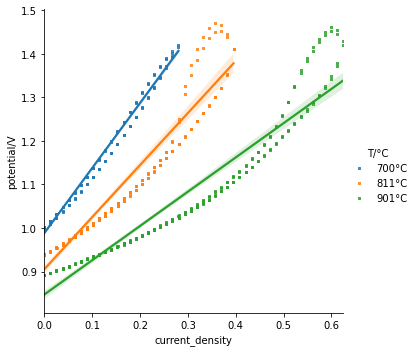

In [5]:
sns.lmplot("current_density", "potential/V", data = df5050, hue = "T/°C", markers=",", scatter_kws={"s": 5})

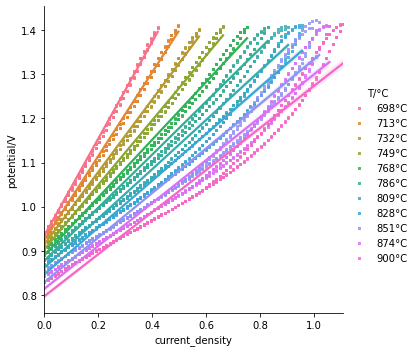

In [6]:
sns.lmplot("current_density", "potential/V", data = df8020, hue = "T/°C", markers=",", scatter_kws={"s": 5})

In [8]:
#start to build the final dataframe as specified in the readme
final_df = pd.DataFrame()
final_df["T/°C"] = combined_df['T/°C'].unique() #copy the temperatures from combined_df
arr = [] #empty arrays to fill with the calculated/extracted values to later append to the final_df
arr2 = []

#in the following we take the temperature to iterate over since those are unique values
for temp in combined_df['T/°C'].unique():
    val = int(combined_df[combined_df['T/°C'] == temp]["CO2/%"].unique()[0])
    val2 = int(combined_df[combined_df['T/°C'] == temp]["CO/%"].unique()[0])
    arr.append(val)
    arr2.append(val2)
    
final_df["CO2/%"] = arr
final_df["CO/%"] = arr2
    

In [9]:
#Determine the Open Circuit Voltage (OCV): this is the potential, where the current is 0
arr = []
for temp in combined_df['T/°C'].unique():
    pot = combined_df[(combined_df["current_density"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'], key=abs)) 
                      & (combined_df["T/°C"]== temp )]['potential/V']
    print(str(temp) + ' has OCV: ' + str(np.mean(pot)))
    arr.append(np.mean(pot))
    
final_df["OCV/V"] = arr

700°C has OCV: 0.9985768
811°C has OCV: 0.9383674999999998
901°C has OCV: 0.8914455000000002
698°C has OCV: 0.9411702666666666
713°C has OCV: 0.9325807142857142
732°C has OCV: 0.9224320000000003
749°C has OCV: 0.9123314999999999
768°C has OCV: 0.9016512500000001
786°C has OCV: 0.8915025000000002
809°C has OCV: 0.8793877500000002
828°C has OCV: 0.8690933333333334
851°C has OCV: 0.8564208000000001
874°C has OCV: 0.8431558500000002
900°C has OCV: 0.8295676500000002


In [10]:
#Determine the Area Specific Resistance (ARS): Calculate the slopes at 100mA
arr = []
for temp in combined_df['T/°C'].unique():
    ars = combined_df[(combined_df["current_density"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'current_density'], key=lambda x:abs(x-0.1))) 
                      & (combined_df["T/°C"]== temp )]['potential/V']
    print(str(temp) + ' has ARS: ' + str(np.mean(ars)))
    arr.append(np.mean(ars))
    
final_df["ASR/ohm cm^2"] = arr

700°C has ARS: 1.1275175
811°C has ARS: 1.0100250000000002
901°C has ARS: 0.934291
698°C has ARS: 1.042235
713°C has ARS: 1.01905
732°C has ARS: 0.9979575
749°C has ARS: 0.9797115000000001
768°C has ARS: 0.959757
786°C has ARS: 0.946026
809°C has ARS: 0.9287795
828°C has ARS: 0.9144315
851°C has ARS: 0.8984679999999999
874°C has ARS: 0.8835495
900°C has ARS: 0.868441


In [11]:
#determine the current density at 1.4 V
arr = []
for temp in combined_df['T/°C'].unique():
    cdy = combined_df[(combined_df["potential/V"] == min(combined_df[combined_df['T/°C'] == temp].loc[:,'potential/V'], key=lambda x:abs(x-1.4))) 
                      & (combined_df["T/°C"]== temp )]['current_density']
    print(str(temp) + ' current density at 1.4V: ' + str(np.mean(cdy)))
    arr.append(np.mean(cdy))
    
final_df["J_1.4V/A cm^2"] = arr

700°C current density at 1.4V: 0.267487898089172
811°C current density at 1.4V: 0.39529171974522287
901°C current density at 1.4V: 0.5608127388535031
698°C current density at 1.4V: 0.4077987261146496
713°C current density at 1.4V: 0.48440382165605095
732°C current density at 1.4V: 0.5737108280254777
749°C current density at 1.4V: 0.6501197452229298
768°C current density at 1.4V: 0.739231847133758
786°C current density at 1.4V: 0.8023528662420383
809°C current density at 1.4V: 0.8789566878980892
828°C current density at 1.4V: 0.9172598726114648
851°C current density at 1.4V: 0.9557566878980891
874°C current density at 1.4V: 1.0192687898089172
900°C current density at 1.4V: 1.0704687898089171


In [12]:
#print the final df to check if everything looks clean and we have no missing values
print(final_df)

     T/°C  CO2/%  CO/%     OCV/V  ASR/ohm cm^2  J_1.4V/A cm^2
0   700°C     50    50  0.998577      1.127517       0.267488
1   811°C     50    50  0.938367      1.010025       0.395292
2   901°C     50    50  0.891446      0.934291       0.560813
3   698°C     80    20  0.941170      1.042235       0.407799
4   713°C     80    20  0.932581      1.019050       0.484404
5   732°C     80    20  0.922432      0.997958       0.573711
6   749°C     80    20  0.912331      0.979712       0.650120
7   768°C     80    20  0.901651      0.959757       0.739232
8   786°C     80    20  0.891503      0.946026       0.802353
9   809°C     80    20  0.879388      0.928779       0.878957
10  828°C     80    20  0.869093      0.914431       0.917260
11  851°C     80    20  0.856421      0.898468       0.955757
12  874°C     80    20  0.843156      0.883549       1.019269
13  900°C     80    20  0.829568      0.868441       1.070469


In [13]:
#export final_df to csv as final_df.csv
final_df.to_csv(r'final_df.csv', index = False, header=True)